In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

import pickle
import numpy as np
f1 = open('data/split_image_0.60_0.30_0.10_aug_to_3000_down_sample_True_instance0-9/train_data0', 'rb')
X_sequence_train, X_feature_train, X_image_train, Y_train = pickle.load(f1)
# X_sequence_train, X_feature_train, Y_train = pickle.load(f1)
f1.close()
f2 = open('data/split_image_0.60_0.30_0.10_aug_to_3000_down_sample_True_instance0-9/val_data', 'rb')
X_sequence_val, X_feature_val, X_image_val, Y_val = pickle.load(f2)
# X_sequence_val, X_feature_val, Y_val = pickle.load(f2)
f2.close()
f3 = open('data/split_image_0.60_0.30_0.10_aug_to_3000_down_sample_True_instance0-9/test_data', 'rb')
X_sequence_test, X_feature_test, X_image_test, Y_test = pickle.load(f3)
# X_sequence_test, X_feature_test,  Y_test = pickle.load(f3)
f3.close()

from keras_preprocessing.sequence import pad_sequences
X_sequence_train_paded = pad_sequences(X_sequence_train, dtype='float', padding='post', value = np.nan)
X_sequence_val_paded = pad_sequences(X_sequence_val, dtype='float', padding='post', value = np.nan)
X_sequence_test_paded = pad_sequences(X_sequence_test, dtype='float', padding='post', value = np.nan)
# 先pad再预处理，因为pad可以把array的list转为ndarray

from util import preprocess
X_sequence_train_trimed = preprocess(X_sequence_train_paded)
X_sequence_val_trimed = preprocess(X_sequence_val_paded)
X_sequence_test_trimed = preprocess(X_sequence_test_paded)

def build_channel(data):
    X = []
    for image in data:
        X.append(image.reshape(128, 128, 1))
    return X
X_image_train = np.array(build_channel(X_image_train))
X_image_val = np.array(build_channel(X_image_val))
X_image_test = np.array(build_channel(X_image_test))
X_feature_train = np.array(X_feature_train)
X_feature_val = np.array(X_feature_val)
X_feature_test = np.array(X_feature_test)
Y_train = np.array(Y_train)-1 # 文件夹名从1开始但是标签从0开始
Y_val = np.array(Y_val)-1
Y_test = np.array(Y_test)-1

2022-11-11 18:42:05.821292: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-11 18:42:05.904778: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
Y_train_one_hot = keras.utils.to_categorical(Y_train, num_classes=11)
Y_val_one_hot = keras.utils.to_categorical(Y_val, num_classes=11)
Y_test_one_hot = keras.utils.to_categorical(Y_test, num_classes=11)

In [ ]:
print(X_feature_test[0])

In [ ]:
f = open('data/split_10fold_No0_aug_to_15000_down_sample_False_instance0-9/class_weights1', 'rb')
train_weight, test_weight = pickle.load(f)
f.close()
print(train_weight)

In [3]:
from mix_models import rnn_with_feature
from mix_models import rnn_with_feature_2
from mix_models import cnn_with_feature_1
from mix_models import cnn_with_feature_2
from mix_models import multi_input_model



# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-3,
#     decay_steps=860,
#     decay_rate=0.85)

# boundaries = [2000]
    # values = [1e-3, 1e-4]
    # lr_schedule= tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    # boundaries, values, name=None
    # )

# strategy = tf.distribute.MirroredStrategy(['GPU:1'])
# print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
# with strategy.scope():


model = multi_input_model(sequence_shape=(None, 3), image_shape=(128, 128, 1), 
                        feature_shape=(2,), num_classes=11, cnn_lr_lamd=10)
# model = rnn_with_feature(sequence_shape=(None, 3),feature_shape=(2,), num_classes=11)
# model = rnn_with_feature2(sequence_shape=(None, 3),feature_shape=(1,), num_classes=11)
# model = cnn_with_feature_2(image_shape=(128, 128, 1), feature_shape=(2,), num_classes=11)
# model = cnn(image_shape=(128, 128, 1), num_classes=11)
# model.summary()
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    # loss="sparse_categorical_crossentropy",
    # loss=categorical_focal_loss(alpha=np.ones(11)),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    # metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    metrics=[keras.metrics.CategoricalAccuracy(name="acc")],
    run_eagerly=False,
)
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath='models/xnn_with_feature_test3/model_{epoch}',
    save_freq='epoch'),
  keras.callbacks.TensorBoard(log_dir='models/xnn_with_feature_test3/logs')
]

2022-11-11 18:42:30.055699: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-11 18:42:30.464915: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22229 MB memory:  -> device: 0, name: GeForce RTX 3090, pci bus id: 0000:73:00.0, compute capability: 8.6


In [4]:
X_train = {'sequence':X_sequence_train_trimed, 'image':X_image_train, 'feature':X_feature_train}
X_val = {'sequence':X_sequence_val_trimed, 'image':X_image_val, 'feature':X_feature_val}


# X_train = {'sequence':X_sequence_train_trimed, 'feature0':X_feature_train[:,0], 'feature1':X_feature_train[:,1]}
# X_val = {'sequence':X_sequence_val_trimed, 'feature0':X_feature_val[:,0], 'feature1':X_feature_val[:,1]}
model.load_weights('models/tmp_weights/rnn_weights_min_loss.h5', by_name=True)
model.fit(X_train, Y_train_one_hot, batch_size=32, epochs=50, 
        validation_data=(X_val, Y_val_one_hot), 
        #  class_weight=dict(enumerate(train_weight)),
        callbacks=callbacks)

Epoch 1/50


2022-11-11 18:42:56.677315: W tensorflow/core/common_runtime/forward_type_inference.cc:332] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT8
    }
  }
}

	while inferring type of node 'cond_43/output/_22'
2022-11-11 18:42:57.509769: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-11-11 18:42:57.509900: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /hom

1032/1032 [==============================] - ETA: 0s - loss: 1.8175 - acc: 0.8077

INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_1/assets


INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_1/assets


1032/1032 [==============================] - 93s 79ms/step - loss: 1.8175 - acc: 0.8077 - val_loss: 0.9748 - val_acc: 0.8189
Epoch 2/50
1031/1032 [============================>.] - ETA: 0s - loss: 0.8616 - acc: 0.8919

INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_2/assets


INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_2/assets


1032/1032 [==============================] - 78s 75ms/step - loss: 0.8616 - acc: 0.8919 - val_loss: 0.9460 - val_acc: 0.8166
Epoch 3/50
1031/1032 [============================>.] - ETA: 0s - loss: 0.8345 - acc: 0.8966

INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_3/assets


INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_3/assets


1032/1032 [==============================] - 77s 74ms/step - loss: 0.8345 - acc: 0.8966 - val_loss: 0.9154 - val_acc: 0.8314
Epoch 4/50
1031/1032 [============================>.] - ETA: 0s - loss: 0.8184 - acc: 0.8979

INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_4/assets


INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_4/assets


1032/1032 [==============================] - 77s 75ms/step - loss: 0.8184 - acc: 0.8980 - val_loss: 0.9176 - val_acc: 0.8316
Epoch 5/50
1032/1032 [==============================] - ETA: 0s - loss: 0.8098 - acc: 0.9004

INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_5/assets


INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_5/assets


1032/1032 [==============================] - 77s 75ms/step - loss: 0.8098 - acc: 0.9004 - val_loss: 0.9186 - val_acc: 0.8250
Epoch 6/50
1031/1032 [============================>.] - ETA: 0s - loss: 0.8037 - acc: 0.9010

INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_6/assets


INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_6/assets


1032/1032 [==============================] - 78s 75ms/step - loss: 0.8037 - acc: 0.9010 - val_loss: 0.9063 - val_acc: 0.8307
Epoch 7/50
1031/1032 [============================>.] - ETA: 0s - loss: 0.8003 - acc: 0.9005

INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_7/assets


INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_7/assets


1032/1032 [==============================] - 77s 75ms/step - loss: 0.8003 - acc: 0.9005 - val_loss: 0.9007 - val_acc: 0.8319
Epoch 8/50
1031/1032 [============================>.] - ETA: 0s - loss: 0.7991 - acc: 0.9029

INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_8/assets


INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_8/assets


1032/1032 [==============================] - 77s 75ms/step - loss: 0.7991 - acc: 0.9030 - val_loss: 0.9090 - val_acc: 0.8235
Epoch 9/50
1031/1032 [============================>.] - ETA: 0s - loss: 0.7944 - acc: 0.9014

INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_9/assets


INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_9/assets


1032/1032 [==============================] - 78s 75ms/step - loss: 0.7944 - acc: 0.9014 - val_loss: 0.9087 - val_acc: 0.8374
Epoch 10/50
1031/1032 [============================>.] - ETA: 0s - loss: 0.7945 - acc: 0.9029

INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_10/assets


INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_10/assets


1032/1032 [==============================] - 77s 75ms/step - loss: 0.7945 - acc: 0.9029 - val_loss: 0.9103 - val_acc: 0.8339
Epoch 11/50
1031/1032 [============================>.] - ETA: 0s - loss: 0.7914 - acc: 0.9025

INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_11/assets


INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_11/assets


1032/1032 [==============================] - 77s 74ms/step - loss: 0.7914 - acc: 0.9025 - val_loss: 0.9042 - val_acc: 0.8265
Epoch 12/50
1032/1032 [==============================] - ETA: 0s - loss: 0.7912 - acc: 0.9019

INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_12/assets


INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_12/assets


1032/1032 [==============================] - 77s 75ms/step - loss: 0.7912 - acc: 0.9019 - val_loss: 0.9127 - val_acc: 0.8339
Epoch 13/50
1031/1032 [============================>.] - ETA: 0s - loss: 0.7901 - acc: 0.9028

INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_13/assets


INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_13/assets


1032/1032 [==============================] - 77s 75ms/step - loss: 0.7901 - acc: 0.9028 - val_loss: 0.9051 - val_acc: 0.8307
Epoch 14/50
1031/1032 [============================>.] - ETA: 0s - loss: 0.7900 - acc: 0.9027

INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_14/assets


INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_14/assets


1032/1032 [==============================] - 77s 75ms/step - loss: 0.7900 - acc: 0.9027 - val_loss: 0.9052 - val_acc: 0.8341
Epoch 15/50
1032/1032 [==============================] - ETA: 0s - loss: 0.7893 - acc: 0.9022

INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_15/assets


INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_15/assets


1032/1032 [==============================] - 78s 75ms/step - loss: 0.7893 - acc: 0.9022 - val_loss: 0.9088 - val_acc: 0.8269
Epoch 16/50
1031/1032 [============================>.] - ETA: 0s - loss: 0.7880 - acc: 0.9032

INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_16/assets


INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_16/assets


1032/1032 [==============================] - 77s 75ms/step - loss: 0.7880 - acc: 0.9032 - val_loss: 0.9069 - val_acc: 0.8340
Epoch 17/50
1031/1032 [============================>.] - ETA: 0s - loss: 0.7878 - acc: 0.9043

INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_17/assets


INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_17/assets


1032/1032 [==============================] - 77s 75ms/step - loss: 0.7879 - acc: 0.9042 - val_loss: 0.9004 - val_acc: 0.8371
Epoch 18/50
1031/1032 [============================>.] - ETA: 0s - loss: 0.7875 - acc: 0.9035

INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_18/assets


INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_18/assets


1032/1032 [==============================] - 77s 75ms/step - loss: 0.7874 - acc: 0.9035 - val_loss: 0.9001 - val_acc: 0.8354
Epoch 19/50
1031/1032 [============================>.] - ETA: 0s - loss: 0.7864 - acc: 0.9033

INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_19/assets


INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_19/assets


1032/1032 [==============================] - 78s 75ms/step - loss: 0.7864 - acc: 0.9033 - val_loss: 0.9049 - val_acc: 0.8288
Epoch 20/50
1032/1032 [==============================] - ETA: 0s - loss: 0.7850 - acc: 0.9034

INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_20/assets


INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_20/assets


1032/1032 [==============================] - 77s 75ms/step - loss: 0.7850 - acc: 0.9034 - val_loss: 0.8991 - val_acc: 0.8377
Epoch 21/50
1031/1032 [============================>.] - ETA: 0s - loss: 0.7842 - acc: 0.9044

INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_21/assets


INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_21/assets


1032/1032 [==============================] - 77s 75ms/step - loss: 0.7842 - acc: 0.9044 - val_loss: 0.9036 - val_acc: 0.8355
Epoch 22/50
1031/1032 [============================>.] - ETA: 0s - loss: 0.7848 - acc: 0.9048

INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_22/assets


INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_22/assets


1032/1032 [==============================] - 78s 75ms/step - loss: 0.7848 - acc: 0.9048 - val_loss: 0.9136 - val_acc: 0.8379
Epoch 23/50
1031/1032 [============================>.] - ETA: 0s - loss: 0.7831 - acc: 0.9060

INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_23/assets


INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_23/assets


1032/1032 [==============================] - 79s 76ms/step - loss: 0.7831 - acc: 0.9060 - val_loss: 0.9008 - val_acc: 0.8304
Epoch 24/50
1031/1032 [============================>.] - ETA: 0s - loss: 0.7831 - acc: 0.9050

INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_24/assets


INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_24/assets


1032/1032 [==============================] - 78s 75ms/step - loss: 0.7831 - acc: 0.9050 - val_loss: 0.8987 - val_acc: 0.8354
Epoch 25/50
1031/1032 [============================>.] - ETA: 0s - loss: 0.7855 - acc: 0.9040

INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_25/assets


INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_25/assets


1032/1032 [==============================] - 77s 75ms/step - loss: 0.7855 - acc: 0.9040 - val_loss: 0.9023 - val_acc: 0.8405
Epoch 26/50
1031/1032 [============================>.] - ETA: 0s - loss: 0.7840 - acc: 0.9050

INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_26/assets


INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_26/assets


1032/1032 [==============================] - 78s 75ms/step - loss: 0.7839 - acc: 0.9051 - val_loss: 0.9141 - val_acc: 0.8245
Epoch 27/50
1031/1032 [============================>.] - ETA: 0s - loss: 0.7841 - acc: 0.9059

INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_27/assets


INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_27/assets


1032/1032 [==============================] - 79s 76ms/step - loss: 0.7841 - acc: 0.9058 - val_loss: 0.9036 - val_acc: 0.8328
Epoch 28/50
1031/1032 [============================>.] - ETA: 0s - loss: 0.7832 - acc: 0.9051

INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_28/assets


INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_28/assets


1032/1032 [==============================] - 78s 76ms/step - loss: 0.7832 - acc: 0.9051 - val_loss: 0.9332 - val_acc: 0.8193
Epoch 29/50
1031/1032 [============================>.] - ETA: 0s - loss: 0.7825 - acc: 0.9039

INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_29/assets


INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_29/assets


1032/1032 [==============================] - 78s 76ms/step - loss: 0.7825 - acc: 0.9039 - val_loss: 0.9065 - val_acc: 0.8209
Epoch 30/50
1032/1032 [==============================] - ETA: 0s - loss: 0.7843 - acc: 0.9067

INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_30/assets


INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_30/assets


1032/1032 [==============================] - 78s 76ms/step - loss: 0.7843 - acc: 0.9067 - val_loss: 0.9096 - val_acc: 0.8355
Epoch 31/50
1031/1032 [============================>.] - ETA: 0s - loss: 0.7818 - acc: 0.9052

INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_31/assets


INFO:tensorflow:Assets written to: models/xnn_with_feature_test3/model_31/assets


1032/1032 [==============================] - 79s 76ms/step - loss: 0.7818 - acc: 0.9052 - val_loss: 0.9056 - val_acc: 0.8286
Epoch 32/50
 157/1032 [===>..........................] - ETA: 33s - loss: 0.7713 - acc: 0.9090

KeyboardInterrupt: 

In [20]:
loaded_model = keras.models.load_model('models/xnn_with_feature_test3/model_6', compile=False)
loaded_model.save_weights('models/tmp_weights/rnn_weights_min_loss.h5')

2022-11-11 18:39:10.116196: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-11 18:39:11.066706: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-11 18:39:11.129912: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-11 18:39:11.361268: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-11 18:39:11.791765: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _ou

2022-11-11 19:24:03.732952: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-11 19:24:04.121103: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-11-11 19:24:04.173706: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-11-11 19:24:04.241523: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-11-11 19:24:04.515869: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _ou

3/3 [==============================] - 3s 86ms/step
Normalized confusion matrix
[[8.27293755e-01 3.85505012e-03 6.93909021e-03 1.08712413e-01
  1.54202005e-03 0.00000000e+00 1.46491904e-02 0.00000000e+00
  0.00000000e+00 3.62374711e-02 7.71010023e-04]
 [8.88888889e-04 8.60444444e-01 1.11111111e-01 1.77777778e-03
  3.55555556e-03 2.66666667e-03 1.68888889e-02 0.00000000e+00
  2.66666667e-03 0.00000000e+00 0.00000000e+00]
 [3.33333333e-02 1.66666667e-01 7.73333333e-01 2.00000000e-02
  0.00000000e+00 0.00000000e+00 6.66666667e-03 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.17647059e-01 0.00000000e+00 0.00000000e+00 8.62745098e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.96078431e-02 0.00000000e+00]
 [1.59574468e-03 8.86524823e-04 8.86524823e-04 3.54609929e-04
  7.20921986e-01 5.33687943e-02 2.16666667e-01 3.54609929e-04
  1.77304965e-03 2.12765957e-03 1.06382979e-03]
 [0.00000000e+00 0.00000000e+00 7.39644970e-04 0.00000000e+0

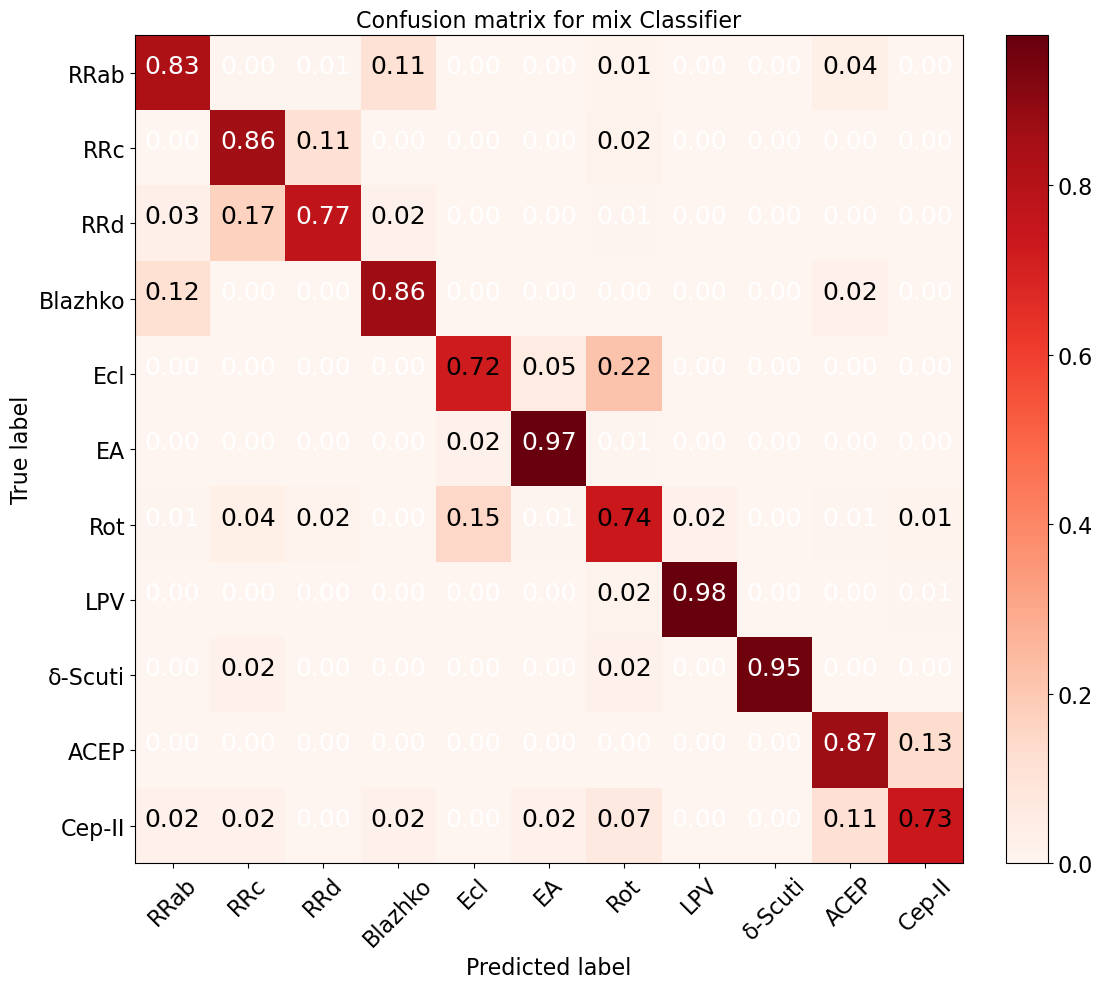

In [5]:
loaded_model = keras.models.load_model('models/xnn_with_feature_test3/model_25', compile=False)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from util import generate_batch

test_gen = generate_batch(X_sequence=X_sequence_test_trimed,X_image=X_image_test,X_feature=X_feature_test, Y=Y_test, batch_size=128)      
y_label = Y_test

y_predict = np.array([])
for x_sequence, x_image, x_feature, y in test_gen:
    y_predict = np.concatenate([y_predict, 
            np.argmax(loaded_model.predict({
                                            'sequence':x_sequence, 
                                            'image':x_image,
                                            'feature':x_feature}), axis=-1)])
y_label = y_label.astype(np.int32) 
y_predict = y_predict.astype(np.int32) 
cm = confusion_matrix(y_true=y_label, y_pred=y_predict, 
                        # labels=[], 
                        # labels用于交换顺序
                        normalize='true')

classes = ['RRab', 'RRc','RRd', 'Blazhko','Ecl', 'EA' , 'Rot', 'LPV','δ-Scuti','ACEP', 'Cep-II']
from util import cm_plot
plotting = cm_plot(cm, classes_types=classes, classifier_model='mix Classifier', nClasses=11,
                    cmap=plt.cm.Blues)

